# Regression Neural Network
This notebook shows a structured workflow to optimize and interpret a three layer neural network. The tutorial starts with some theory and data preparation. This is followed by a simple three-layer neural network, that is used to determine a suitable dimensionality for the hidden layer. Afterwards, we build an ensemble of this model. To determine the relevant input features, a sensitivity analysis is performed.
At the end, a deep version of a three-layer neural network is constructed, and we calculate an ensemble of it.

## Theory
It is proven that three-layer neural networks can approximate any continuous function on a compact domain to any given level, if the hidden layer is big enough (Hornik, Stinchcombe, White 1989). Nevertheless, it is often complex to create a well performing neural network for a regression task. One problem is to find a suitable hidden layer size or the relevant input features. The notebook presents approaches to alleviate these problems.

In [ ]:
import sys
import os

sys.path.append(os.path.abspath("../../.."))
sys.path.append(os.path.abspath(".."))

In [25]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn

from prosper_nn.utils.neuron_correlation_hidden_layers import (
    hl_size_analysis_Sequential,
)
from prosper_nn.utils.sensitivity_analysis import sensitivity_analysis
import prosper_nn.models.ensemble as ensemble
import prosper_nn.models.deep_feed_forward as deepff
import prosper_nn.models.feedforward as feedforward
import tutorials.dataset as dataset
torch.manual_seed(0)

## Data Preparation
To show the workflow with Prosper_nn, a dataset with 1599 different red wines and 11 features about chemical properties `X` is loaded (see [1]). We rank the quality `y` of the wine. The dataset can be downloaded from [2].

The dataset is shuffled and split into training and test sets. Afterwards we normalize them independently of each other.
At the end, the training set is formatted into batches with the chosen **batchsize**. The remaining instances are dropped.

##### References

[1] P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science


In [26]:
batchsize = 16

In [27]:
df = pd.read_csv("data/winequality-red.csv", sep=";").sample(frac=1)

X = torch.tensor(df.drop(columns=["quality"]).values).float()
y = torch.tensor(df["quality"].values).float()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Normalize data
normalize_data = lambda x: (x - x.mean(dim=0)) / x.std(dim=0)
X_train = normalize_data(X_train)
X_test = normalize_data(X_test)
y_train = normalize_data(y_train).reshape(-1, 1)
y_test = normalize_data(y_test).reshape(-1, 1)

# Bring the data in batch format
X_train = X_train[: -(X_train.shape[0] % batchsize)]
y_train = y_train[: -(y_train.shape[0] % batchsize)]
X_train = X_train.reshape(int(X_train.shape[0] / batchsize), batchsize, -1)
y_train = y_train.reshape(int(y_train.shape[0] / batchsize), batchsize, -1)

## Single Three-Layer Feedforward Neural Network
A [three-layer feedforward neural network](../api/feedforward.rst) is the simplest non-linear neural network. It can be described by using two matrices and a non-linearity like e.g. $\tanh$.
The architecture is shown below.

<img src=images/feedforward.png width=200 >

### Initialization
To initialize a three-layer Feedforward Neural Network there are some parameters to chose. Some are already given by the data. As instance, the **input_dimension** is equal to the number of input features - 11 in our case. The **output_dimension** is defined by the task. Here, we predict one feature, the wine quality. Setting the right value for **hidden_dimension** gets more complicated. The first choice is more or less a guess. But the [Pearson Correlation Coefficient](../api/neuron_correlation_hidden_layer.rst) is presented later that estimates if the value should be increased or decreased. 

In [28]:
input_dim = 11
hidden_dim = 20
output_dim = 1

n_epochs = 400

In [29]:
ffnn = feedforward.FFNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)

Set the optimizer and the loss function.

In [30]:
optimizer = optim.Adam(ffnn.parameters(), lr=0.001)
loss_function = nn.MSELoss()

### Training Loop
In PyTorch, a training loop consists of several steps. For each epoch and for each batch in the training set, the saved gradients in the model parameters are set to zero.
Then a batch is given to the model, and it calculates the predictions. They are compared to the true values using a loss function. This loss is backpropagated through the model and new gradients are set to the model weights. At the end, an optimizer step is executed and the weights are updated.

In [31]:
losses = [0] * n_epochs

for epoch in range(n_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        ffnn.zero_grad()
        y_pred = ffnn(X_batch)
        loss = loss_function(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        losses[epoch] += loss.detach()

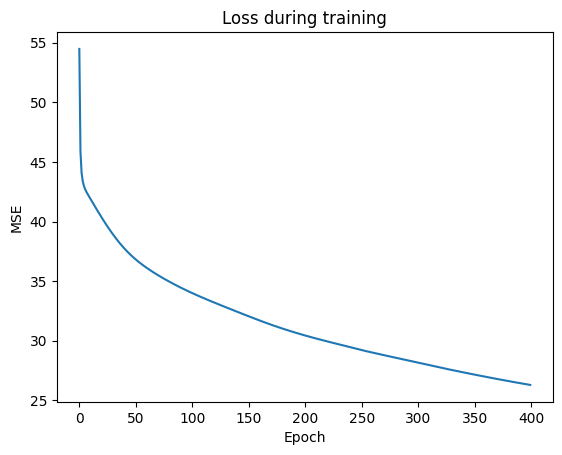

In [32]:
def visualize_learning_process(n_epochs, losses):
    plt.plot(range(n_epochs), losses)
    plt.title("Loss during training")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.show()


visualize_learning_process(n_epochs, losses)


### Prediction
To verify if the model is well-trained, calculate and print out the Mean Squared Error Loss for the training and test data set. Here, the model might be overfitted.

In [33]:
with torch.no_grad():
    y_pred_train = ffnn(X_train)
    y_pred_test = ffnn(X_test)
    error_train = loss_function(y_pred_train, y_train)
    error_test = loss_function(y_pred_test, y_test)

print("Error training data: " + str(round(error_train.item(), 6)))
print("Error test data: " + str(round(error_test.item(), 6)))

Error training data: 0.390196
Error test data: 0.661699


### Evaluation
#### Determine Hidden Layer Dimensionality

As already mentioned, the hidden layer size is only a guess a priori. But after the model is trained, we can check if the model is trained well.
Therefore, we look at the Pearson correlation coefficient between the neurons of the hidden state:

$$\langle f_i, f_j \rangle = \frac{\sum_t \left (f_i(t)-\overline{f}_i \right ) \left( f_j(t) - \overline{f}_j \right)}{\sqrt{\sum_t \left (f_i(t)-\overline{f}_i \right )^2 \sum_t \left( f_j(t) - \overline{f}_j \right)^2}}$$

where $f_i$ is the value and $\overline{f}_i$ the mean of the i-th neuron.

If two or more neurons are highly correlated, only one of them is needed and the others are redundant, if the neuron weight is increased. Then the size of the hidden layer (i.e. hidden_dim) can be reduced. On the other hand, if none of the neurons have outputs with a strongly correlation, we should set hidden_dim to a larger number. The [hiddenlayer size analysis](../api/neuron_correlation_hidden_layer.rst) gives us a plot of the correlations between neurons with color coding and the values of the correlation for relatively strong ones. 

As a rule of thumb, we have a suitable dimensionality when the highest correlation is around 80 percent.

The analysis refers to the last module of the following model: 
Sequential(
  (0): Linear(in_features=11, out_features=20, bias=True)
)


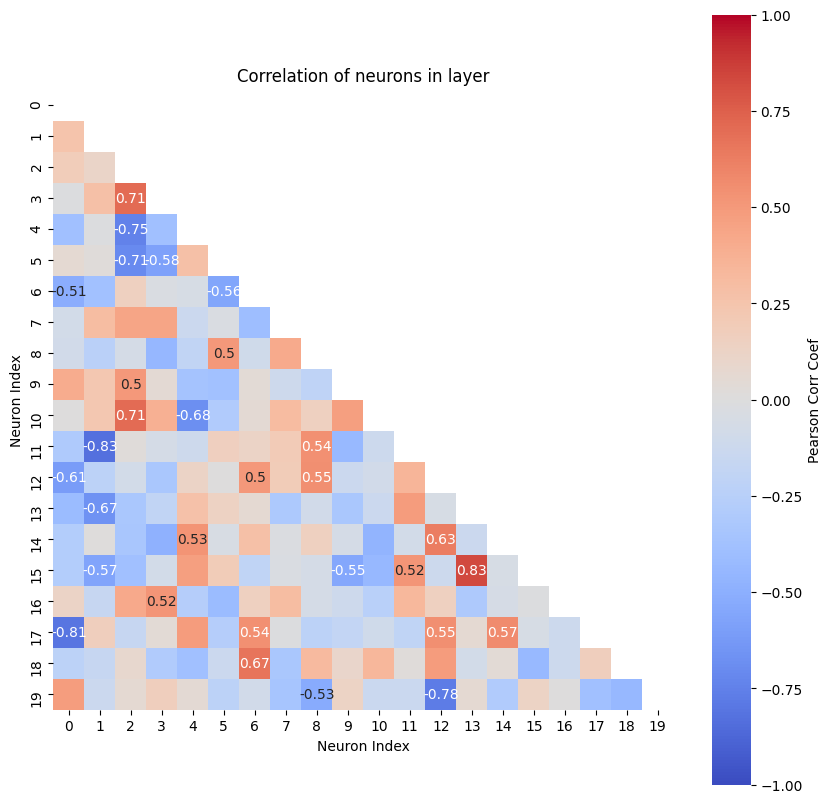

The Neurons tensor([[15, 13],
        [11,  1]]) have the highest correlation with tensor([[-0.8300],
        [ 0.8300]])


In [34]:
corr_matrix, max_corr, ind_neurons = hl_size_analysis_Sequential(
    ffnn,
    X_train.view(X_train.shape[0] * X_train.shape[1], -1),
    min_absolute_corr=0.5,
    print_values=False,
    name_layer="hidden",
)

print(f'The Neurons {ind_neurons} have the highest correlation with {max_corr}')

Result: Highest Pearson correlation coefficient for a neuron is ~0.83. The size of the hidden layer is already a good guess, but maybe the size could be decreased a little bit.

## Ensemble of Three-Layer feedforward neural network
Training the same model multiple times will give strongly differing predictions due to over-parametrization and the random initialization of the model. It is unclear which of these models gives the best prediction, because they all perform equally well on the training set and therefore are equally right.
One approach to handle this issue is building an [ensemble](../api/ensemble.rst) of these models. Several Feedforward Neural Networks are trained independently. As a final prediction, their output is combined by calculating the median or mean of the individual model outputs. In this way, the error decreases and the model predicts more reliable.

<img src=images/ens_feedforward.png width=300 >

As with the single model we first initialize the ensemble, then train it and then use it for forecasting. Lastly, we evaluate the trained ensemble.

### Initialization
First, we initialize a three-layer feedforward neural network as the base model. Then the number of models in the ensemble (**n_models**) is set. It is recommended to use more than 25 models to get trustworthy results.


In [35]:
base_model = feedforward.FFNN(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim
)

In [36]:
n_models = 5
ensemble_model = ensemble.Ensemble(model=base_model, n_models=n_models)

c:\Users\bkn\Projekte\Prosper\prosper\prosper_nn\models\ensemble\ensemble.py:37: UserWarning: Bias could not be initialized with wished init function.Instead torch.nn.init.normal_ is chosen.
  ----------


Reset the optimizer.

In [37]:
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

### Training Loop
The training loop is similar to that of the single feedforward model. The difference lies in the output of the ensemble model and the loss calculation. The ensemble output is composed of the individual model outputs in the first n_models entries, and the combined output in the last entry. So, the output of the ensemble has to be split in the submodel predictions `y_preds` and the mean prediction `mean`. Add the loss of all predictions in y_preds and use this value for backpropagation. The mean prediction is used for the final prediction.

In [38]:
losses = [0] * n_epochs

# Training
for epoch in range(n_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        ensemble_model.zero_grad()
        y_preds, mean = torch.split(ensemble_model(X_batch), n_models)
        loss = sum([loss_function(y_pred, y_batch) for y_pred in y_preds]) / n_models
        loss.backward()
        optimizer.step()
        loss_mean = loss_function(mean.squeeze(0), y_batch)
        losses[epoch] += loss_mean.detach()

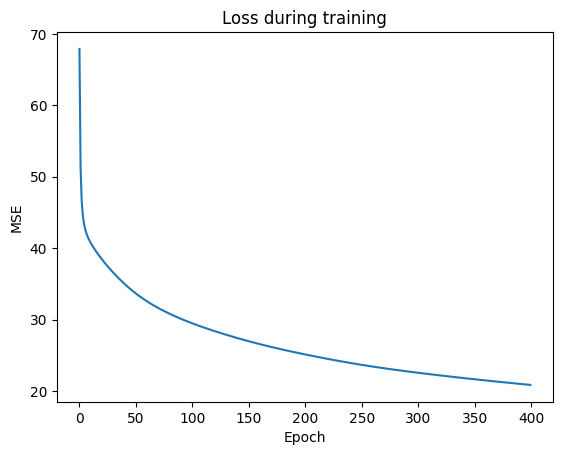

In [39]:
visualize_learning_process(n_epochs, losses)

### Prediction
Calculate the error for train and test data with the mean prediction using the ensemble_model, and print out the Mean Squared Error Loss for the training and test data set.

In [40]:
with torch.no_grad():
    _, y_pred_train_mean = torch.split(ensemble_model(X_train), n_models)
    _, y_pred_test_mean = torch.split(ensemble_model(X_test), n_models)
    error_train = loss_function(y_pred_train_mean.squeeze(0), y_train)
    error_test = loss_function(y_pred_test_mean.squeeze(0), y_test)

print("Error training data: " + str(round(error_train.item(), 6)))
print("Error test data: " + str(round(error_test.item(), 6)))

Error training data: 0.309446
Error test data: 0.597933


### Evaluation

#### Check Input/Output Sensitivity

The [sensitivity analysis](../api/sensitivity_analysis.rst#prosper_nn.utils.sensitivity_analysis.sensitivity_analysis) function allows us to investigate the relationship between input features and output. For that, the gradient of the output with respect to the input $\frac{\partial output}{\partial input}$ is calculated. For one observation this means that there exists a neighborhood around the input vector for which we know if the output will increase or decrease when we change an input feature a little. If the derivation is positive, the output will increase when the feature increases and will decrease when the feature decreases. If the derivation is negative, the relationship is reversed (input increased $\rightarrow$ output decreases, input decreased $\rightarrow$ output increases). 

If observations cover the input space, global relations follow. The relationship of one feature to the output can be determined by looking at the derivations of one feature for all observations. The sensitivity analysis function allows to investigate this graphically by representing positive gradients red and negative ones blue. Stronger colors represent a stronger relation of the feature to the output.

* derivations w.r.t. the feature constant, i.e. color across observations in row of feature roughly the same $\longrightarrow$ linear relationship between input feature and output
* derivations monotone, i.e. all red or all blue across observations in row of features $\longrightarrow$ monotonic relationship between input feature and output
* derivations with changing signum, i.e. there's both red and blue in the feature's row $\longrightarrow$ non-monotonic relationship between input feature and output, e.g. quadratic or sine
* derivations close to 0, i.e. very light color in the feature's row $\longrightarrow$ unnecessary feature as no influence of input feature on output is found


With the `output_neuron` parameter it can be navigated in the model output to the neuron for which the analysis should be performed. It is used as a slice on the model output. In this example this means to use the mean prediction of the ensemble for the analysis. This should always be done because an individual model can create wrong results.


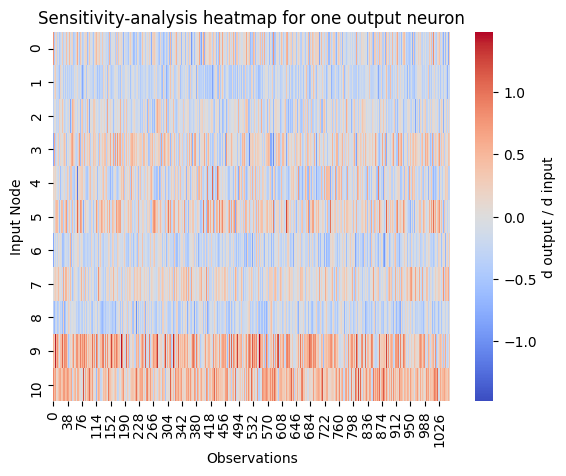

In [41]:
sensitivity = sensitivity_analysis(
    model=ensemble_model,
    data=X_train.view(X_train.shape[0] * X_train.shape[1], -1),
    output_neuron=[-1],
    batchsize=1,
)

In the output we see that there is no feature with a linear relation to the wine quality. But there are features with a monotone relation to the output. For example, feature 9 has a strong positive monotonic relationship. Trying to increase this feature will improve the wine quality.
We also conclude that feature 7 is not important for the output. Leaving this feature out of the model might not affect the error or will even increase the performance.

After the sensitivity analysis, the steps presented in the notebook have to be repeated until the model has a correct hidden layer dimension and no unnecessary input features. 

## Deep Feedforward Neural Network
If the results are still not good enough, the [Deep Feedforward Neural Network](../api/deepff.rst) is an option to improve the performance. We use a feedforward model as the base estimator. The output of the model is propagated to another feedforward network with the goal to only explain the remaining error of the first model. This approach can be continued with further feedforward networks. There is no backward connection between the output layer and the layer before, so the prediction is only propagated in the forward direction to the output layer of the next level.

<img src=images/deepff.png width=400 >

### Initialization
The initialization of the model is identical except for the additional **deepness** parameter. It represents the number of hidden layers in the neural network. It corresponds with the number of feedforward neural network paths to an output layer. A deepness of one creates a simple feedforward neural network.

In [42]:
deepness = 3

In [43]:
deep_ff = deepff.DeepFeedForward(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, deepness=deepness
)

Reset the optimizer.

In [44]:
optimizer = optim.Adam(deep_ff.parameters(), lr=0.001)

### Training Loop
Again, the training loop has to be modified a little. The output of the model consists of the outputs from the different levels. The losses of all the deepness levels have to be added and the sum is used for backpropagation.
As final prediction, we use the output of the highest level.

In [45]:
losses = [0] * n_epochs

# Training
for epoch in range(n_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        deep_ff.zero_grad()
        y_preds = deep_ff(X_batch)
        loss = [loss_function(y_preds[j], y_batch) for j in range(deepness)]
        loss = sum(loss) / deepness
        loss.backward()
        optimizer.step()
        loss_mean = loss_function(y_preds[-1], y_batch)
        losses[epoch] += loss_mean.detach()

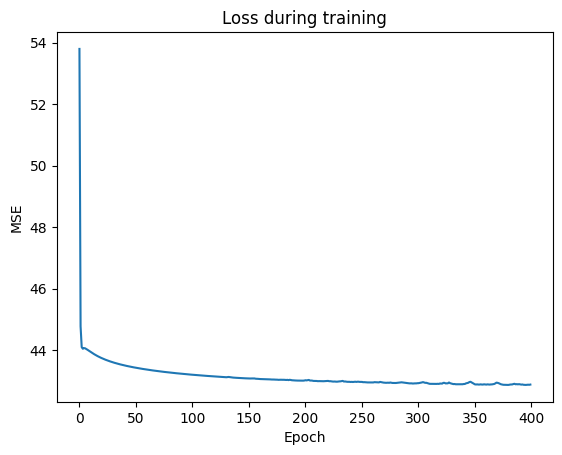

In [46]:
visualize_learning_process(n_epochs, losses)

### Prediction
Calculate error for train and test data using the just trained model and print out the Mean Squared Error Loss for the training and test data set.

In [47]:
with torch.no_grad():
    y_pred_train = deep_ff(X_train.view(-1, 11))
    y_pred_test = deep_ff(X_test)
    error_train = loss_function(y_pred_train[-1], y_train.view(-1, 1))
    error_test = loss_function(y_pred_test[-1], y_test)

print("Error training data: " + str(error_train.item()))
print("Error test data: " + str(error_test.item()))

Error training data: 0.6456071138381958
Error test data: 0.6243733763694763


## Ensemble of Deep Feedforward Neural Network
To increase the performance of the deep feedforward network, it is again recommended to build an ensemble of these models.

<img src=images/ens_deepff.png width=600 >

### Initialization
The initialization of the ensemble is identical to that of a simple feedforward network.

In [48]:
deep_ff = deepff.DeepFeedForward(
    input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, deepness=deepness
)

ens_deep_ff = ensemble.Ensemble(model=deep_ff, n_models=n_models)

Reset the optimizer.

In [49]:
optimizer = optim.Adam(ens_deep_ff.parameters(), lr=0.001)

### Training Loop
The output of the ensemble model has again one more dimension compared to the deep feed forward model. It has  `shape = (n_models + 1, deepness, input_dim)` and the loss has to be calculated for all submodels (first `n_models`) and all levels of deepness. 
The most reliable  prediction is expected in the mean output of the ensemble and the highest level of the deep feedforward model (`best_prediction = ens_deep_ff(X)[-1, -1]`). 

In [50]:
losses = [0] * n_epochs

# Training
for epoch in range(n_epochs):
    for X_batch, y_batch in zip(X_train, y_train):
        ens_deep_ff.zero_grad()
        y_preds, mean = torch.split(ens_deep_ff(X_batch), n_models)
        loss = [
            loss_function(y_preds[i][j], y_batch)
            for j in range(deepness)
            for i in range(n_models)
        ]
        loss = sum(loss) / (n_models * deepness)
        loss.backward()
        optimizer.step()
        loss_mean = loss_function(mean[0, -1], y_batch)
        losses[epoch] += loss_mean.detach()

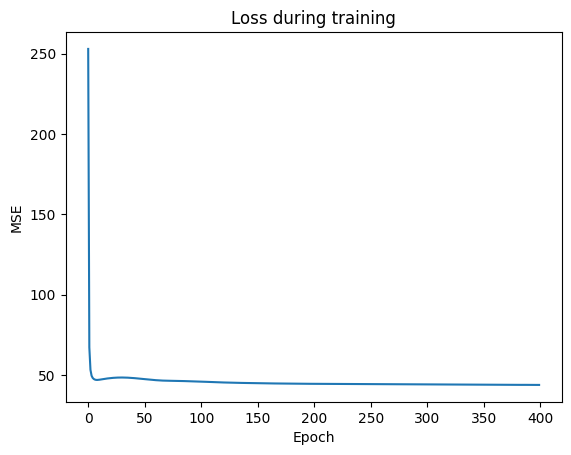

In [51]:
visualize_learning_process(n_epochs, losses)

### Prediction
Calculate error for train and test data using the trained model and print out the Mean Squared Error Loss for the training and test data set.

In [52]:
with torch.no_grad():
    _, y_pred_train_mean = torch.split(ens_deep_ff(X_train.view(-1, 11)), n_models)
    _, y_pred_test_mean = torch.split(ens_deep_ff(X_test), n_models)
    error_train = loss_function(y_pred_train_mean[-1, -1], y_train.view(-1, 1))
    error_test = loss_function(y_pred_test_mean[-1, -1], y_test)

print("Error training data: " + str(error_train.item()))
print("Error test data: " + str(error_test.item()))

Error training data: 0.6495721936225891
Error test data: 0.6353241801261902
